In [1]:
### loading dataset
%matplotlib widget

from essential_func import *
### load bkg data data
import sys, os
sys.path.insert(1, os.path.join(os.getcwd(), 'ML', 'dataloader'))
from lesions import *
from scipy import stats 

# specs
qgrid2 = np.hstack([np.arange(0.005, 0.0499, 0.001), np.arange(0.05, 0.099, 0.002), np.arange(0.1, 3.2, 0.005)])
lidx =  qgrid_to_indices(qgrid2, 0.4)
uidx =  qgrid_to_indices(qgrid2, 2.0)
column_names= {"bkg":1.}    # {"Diffuse_Plaque":0., "Neurofibrillary_Tangle_(tau)":1. , "Tau":2. ,"Neuritic_Plaque":3., "Tissue":4., "bkg":5.0 }
Excel_File  = "/Users/bashit.a/Documents/Alzheimer/Mar-2023/Mar-2023-Samples-updated.xlsx"   # "/home/bashit.a/Codes/ML/Mar-2023-Samples.xlsx"   "/Users/bashit.a/Documents/Alzheimer/Mar-2023/Mar-2023-Samples.xlsx"    sheet       = 'Mar-2023-Samples'
BNL_dir     = '/Volumes/HDD/BNL-Data/Mar-2023'    # '/Volumes/HDD/BNL-Data/Mar-2023'         '/scratch/bashit.a/BNL-Data/Mar-2023'
sub_dir     = "CSV_Conv-8-point"  # CSV_Conv-8-point  CSV
val_files   = None # ["1898_CING-roi0_0_0_masked_intp.h5", "1948_EC-roi1_0_0_masked.h5","1948 V1-roi0_0_0_masked.h5","1948_PHG-roi1_0_0_masked.h5"] # None ["1948_HIPPO-roi1_0_0_masked_intp.h5", "2428-roi1_0_0_masked_intp.h5"]
sheet       = 'Mar-2023-Samples'
mica_sub    = False
scaling     = False
tissue_sub  = False

# loading dataset_bkg for visualizing and later on will be split into train, validation, and test set
column_names     = {"bkg":1.}
batch_size       = 1024
split_dataset    = train_val_split_dataset(get_dataframe_with_files_loc)
df_train, _      = split_dataset(Excel_File, sheet, BNL_dir, sub_dir, val_files)
dataset_bkg      = XrayData(df_train, column_names, BNL_dir, sub_dir, lidx=lidx, uidx=uidx, mica_sub=mica_sub, scaling=scaling, tissue_sub=tissue_sub)

# loading dataset_tissue for testing
column_names       = {"Tissue":0.}
batch_size         = 1
split_dataset      = train_val_split_dataset(get_dataframe_with_files_loc)
df_train, _        = split_dataset(Excel_File, sheet, BNL_dir, sub_dir, val_files)
dataset_tissue     = XrayData(df_train, column_names, BNL_dir, sub_dir, lidx=lidx, uidx=uidx, mica_sub=mica_sub, scaling=scaling, tissue_sub=tissue_sub)
dataloader_tissue  = DataLoader(dataset_tissue, batch_size=batch_size, num_workers=0)

bkg : contains 94 samples
Tissue : contains 358 samples


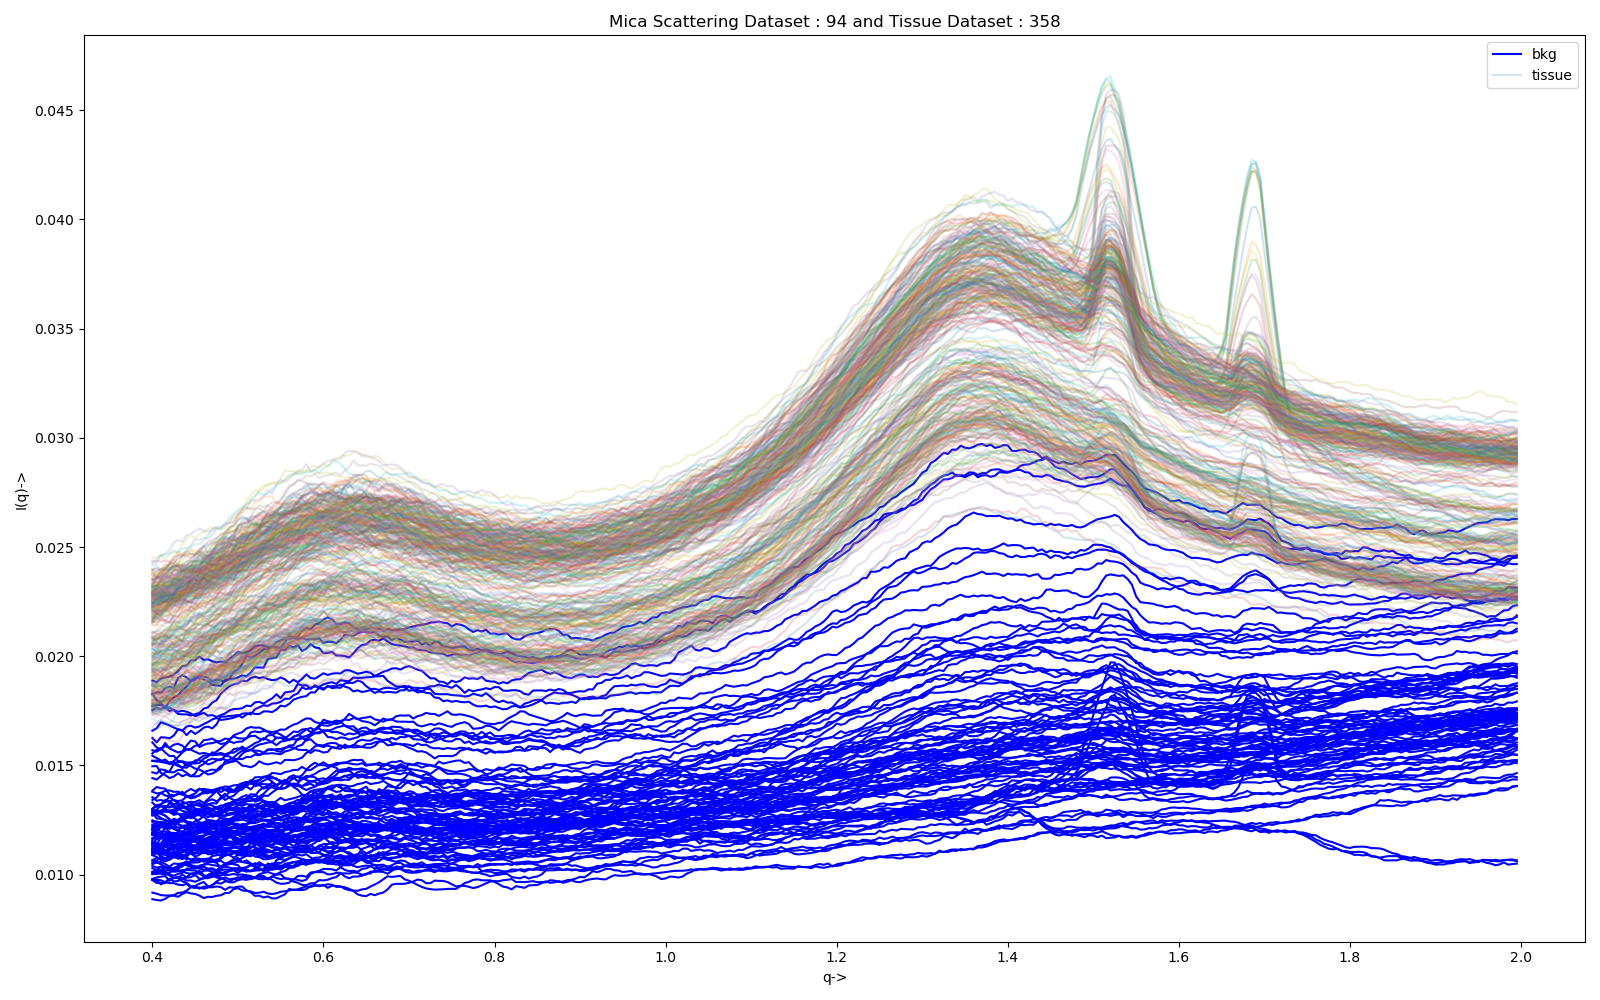

In [2]:
### visualize bkg dataset

plt.close('all')
plt.figure(figsize=(16,10))
bkg_plot   = plt.plot(qgrid2[lidx:uidx], dataset_bkg.x.T, color='blue')
tissue_plt = plt.plot(qgrid2[lidx:uidx], dataset_tissue.x.T, alpha=0.2)
plt.xlabel('q->')
plt.ylabel('I(q)->')
plt.title(f'Mica Scattering Dataset : {len(dataset_bkg.x)} and Tissue Dataset : {len(dataset_tissue.x)}')
plt.tight_layout()
plt.legend([bkg_plot[0], tissue_plt[0]],['bkg','tissue'])
plt.show()

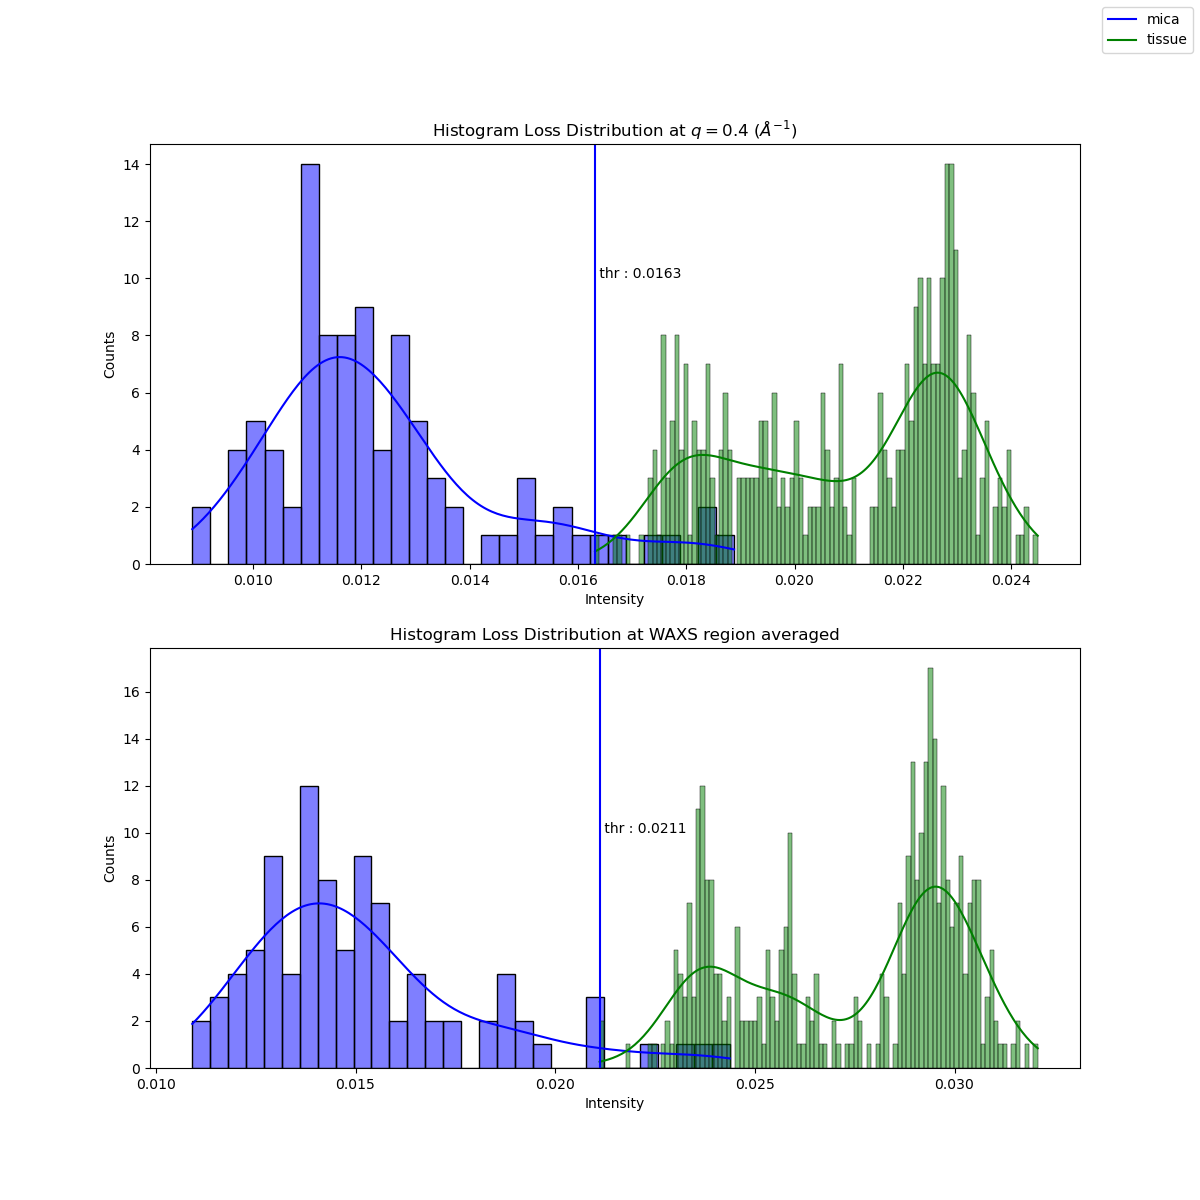

q = circ for avgerage WAXS intensity, and thr : 0.0211


In [11]:
#### method - Thresholding
### tradional thresholding - using histogram from one q point or averaging
import seaborn as sns

### ----------- spec ----------- 
q_idx = [0, 'circ']  #  [0, 'circ']   q_idx = 0 means q=0.4 , q_idx = 188 means q=1.34
q     = (0.4, 'avgerage WAXS intensity')  # (0.4, 'avgerage WAXS intensity')
### ----------------------------

### variable that tells the method to choose threshold - trad_threshold
method = 'thresholding'

### computation
plt.close('all')
f,axs = plt.subplots(ncols=1,nrows=2, figsize=(12,12))

for i in range(len(q_idx)):
    dtype = isinstance(q_idx[i],int) or isinstance(q_idx[i],float)
    if dtype:
        bkg_rep    = dataset_bkg.x[:,q_idx[i]]
        tissue_rep = dataset_tissue.x[:,q_idx[i]]
    else:
        bkg_rep    = dataset_bkg.x.mean(axis=1)
        tissue_rep = dataset_tissue.x.mean(axis=1)
    
    lower_threshold = bkg_rep.min()
    trad_threshold  = tissue_rep.min()  # tissue_rep.min()  np.percentile(tissue_rep, 1)
    
    axs[i].set_title(f'Histogram Loss Distribution at $q = $' + f'{q[i]}' + " $(\AA^{-1})$" if dtype else f'Histogram Loss Distribution at WAXS region averaged'    )
    sns.histplot(bkg_rep,bins=30,kde=True, color='blue',ax=axs[i])
    sns.histplot(tissue_rep,bins=100,kde=True, color='green',ax=axs[i])
    axs[i].axvline(trad_threshold, 0.0, 10, color='blue')
    axs[i].set_xlabel("Intensity")
    axs[i].set_ylabel("Counts")
    axs[i].annotate(f' thr : {trad_threshold:0.4f}', (trad_threshold,10))

f.legend(['mica','tissue'])
plt.show()
print(f'q = {q_idx[i]} for {q[i]}, and thr : {trad_threshold:0.4f}')

In [12]:
#### method - Anomaly Detection
# split - dataset_bkg for training, validation and testing Also 
from torchsummary import summary

split_dataset = {'train': 0.6, 'val':0.2, 'test': 0.2}
batch_size = {'train_batch': 1024, 'val_batch': 1024, 'test_batch': 1}
shuffle_dataset = True
random_seed = 42

np.random.seed(random_seed)
assert sum(list(split_dataset.values())) == 1.0 , 'check if split dataset sums to 1.0'

# Creating data indices for training and validation splits:
indices = np.arange(0,len(dataset_bkg))
if shuffle_dataset :
    np.random.shuffle(indices)

split   = int(split_dataset['train']*len(dataset_bkg))
train_indices, test_indices = indices[:split], indices[split:]
print(f'train size : {len(train_indices)}, test size w/o val : {len(test_indices)}, Total {len(train_indices)+len(test_indices)}')
train_sampler = SubsetRandomSampler(train_indices)
training_loader   = DataLoader(dataset_bkg, batch_size=batch_size['train_batch'], sampler=train_sampler, num_workers=0)

### work on test_indices if validatoin available
validation_loader = 0
if split_dataset.get('val',0):
    new_split_ratio = split_dataset['val']/(split_dataset['val']+ split_dataset['test'])
    split           = int(new_split_ratio*len(test_indices))    
    val_indices, test_indices = test_indices[:split], test_indices[split:]
    print(f'train size: {len(train_indices)}, val size: {len(val_indices)}, test size: {len(test_indices)}, Total {len(train_indices)+len(val_indices)+len(test_indices)}')
    
    valid_sampler = SubsetRandomSampler(val_indices)
    validation_loader = DataLoader(dataset_bkg, batch_size=batch_size['val_batch'], sampler=valid_sampler, num_workers=0)

test_sampler  = SubsetRandomSampler(test_indices)
test_loader   = DataLoader(dataset_bkg, batch_size=batch_size['test_batch'], sampler=test_sampler, num_workers=0)

if validation_loader:
    print("training_loader size : {} ; validation_loader size : {}, test_loader size : {}".format(len(training_loader), len(validation_loader), len(test_loader)))
else:
    print("training_loader size : {} ; test_loader size : {}".format(len(training_loader), len(test_loader)))
### test indices
# train_indices, val_indices, test_indices

train size : 56, test size w/o val : 38, Total 94
train size: 56, val size: 19, test size: 19, Total 94
training_loader size : 1 ; validation_loader size : 1, test_loader size : 19


Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1, 320]              --
|    └─Conv1d: 2-1                       [-1, 1, 320]              1
|    └─ReLU: 2-2                         [-1, 1, 320]              --
Total params: 1
Trainable params: 1
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
model saved to : /Users/bashit.a/Documents/Alzheimer/Codes/ML/models/saved-models/micaAE.model


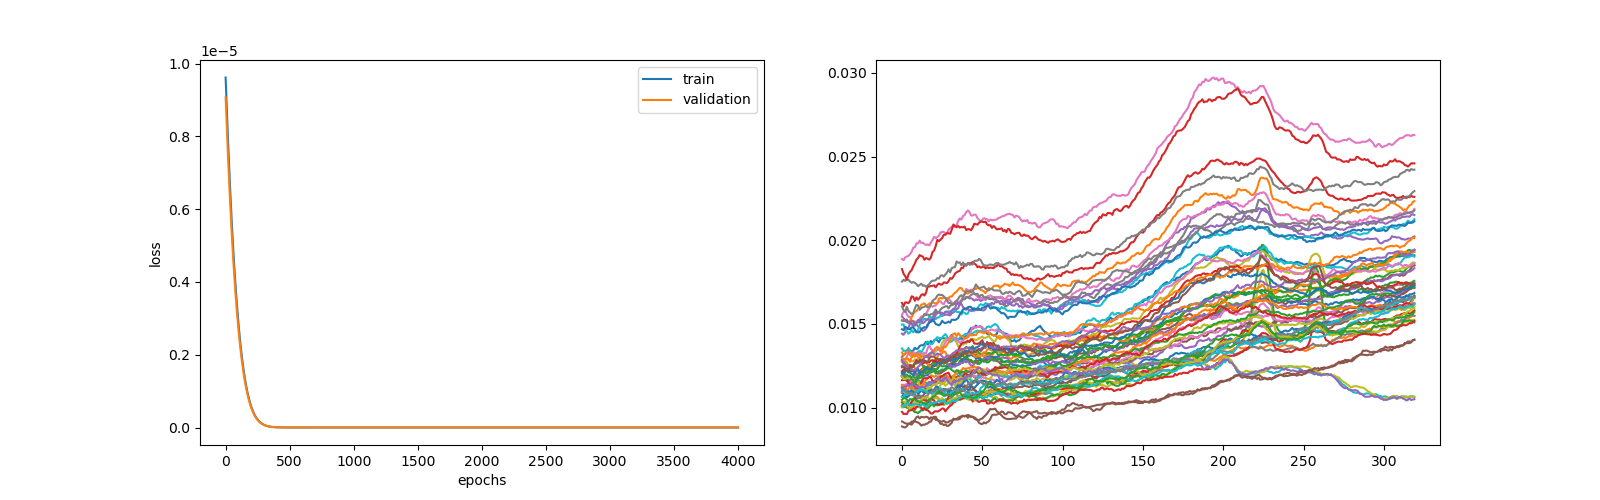

DescribeResult(nobs=4000, minmax=(1.024377410017403e-17, 9.618345757189672e-06), mean=1.8912646262639934e-07, variance=9.672226339395641e-13, skewness=6.476607798507006, kurtosis=44.98373532110859)
DescribeResult(nobs=4000, minmax=(1.0191500421363742e-17, 9.074757144844625e-06), mean=1.7795728994951946e-07, variance=8.583602591339678e-13, skewness=6.485661514829183, kurtosis=45.1178313779695)


In [13]:
#### method - Anomaly Detection
### Train a model

### import packages
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import pylab as plt
from torchsummary import summary

### specs
destination = "/Users/bashit.a/Documents/Alzheimer/Codes/ML/models/saved-models/micaAE.model"
epochs = 4000
learning_rate = 0.001
input_scale = 1
torch.manual_seed(30)

### model architecture
class LinearModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=1, kernel_size=1, stride=1, padding=0, bias=False),
            # nn.LeakyReLU(negative_slope=1),  # seed - 12
            nn.ReLU()   # seed - 30,  nn.ReLU()
        )
    
    def forward(self, x):
        x = self.linear(x)
        return x

### model parameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model =  LinearModel()
model.to(device)
summary(model, (1,320))
criterion  = nn.MSELoss()
optimizer  = torch.optim.Adam(model.parameters(), lr=learning_rate)


### create loss array
train_loss = np.array([])
val_loss   = np.array([])
parameter  = np.array([])

if validation_loader:
    val_in = next(iter(validation_loader))[0]
    val_in = input_scale*val_in.unsqueeze(1).to(device)

epoch  = 1 
while epoch <= epochs:
    model.train()
    ### run on training dataset
    for bx, (input, label) in enumerate(training_loader):
        input = input_scale*input.unsqueeze(1).to(device)
        model.train()
        target = model(input)
        loss = criterion(input, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss = np.hstack((train_loss,loss.item()))
    
    ### check the parameter value
    for name, param in model.named_parameters():
        if param.requires_grad:
            parameter = np.hstack((parameter, param.data.squeeze(0).squeeze(0).squeeze(0)))
    
    ### run on testing dataset
    if validation_loader:
        model.eval()
        with torch.no_grad():
            ypred  = model(val_in)
            val_loss_fn  = criterion(val_in, ypred)
            val_loss = np.hstack((val_loss, val_loss_fn.item()))
    epoch += 1

### saving model
print(f'model saved to : {destination}')
torch.save(model.state_dict(), destination)

### plot training results
plt.close('all')
f, axs = plt.subplots(ncols=2, nrows=1, figsize=(16,5))
axs[0].plot(train_loss, label='train')
axs[0].plot(val_loss, label='validation')
axs[0].set_xlabel('epochs')
axs[0].set_ylabel('loss')
axs[0].legend()
axs[1].plot(input_scale*target.squeeze(1).detach().numpy().T)
plt.show()
print(stats.describe( train_loss))
if validation_loader:
    print(stats.describe( val_loss))

At 4001 train loss: 1.024377410017403e-17, val loss: 1.0191500421363742e-17, parameter : 0.9999998211860657


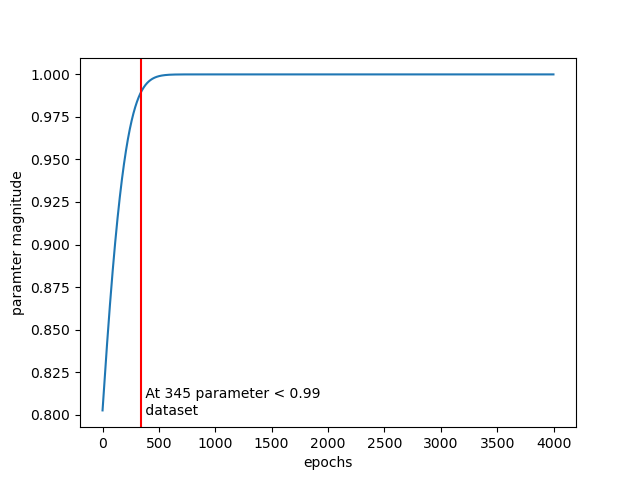

In [14]:
### checking model parameter over epochs

f, ax = plt.subplots()
ax.plot(parameter)
ax.set_xlabel('epochs')
ax.set_ylabel('paramter magnitude')
itr = np.argmin(parameter<0.99)
plt.axvline(itr, 0.0, 1.0, color='red')
plt.annotate(f' At {itr} parameter < 0.99 \n dataset', (itr,0.8))
print(f'At {epoch} train loss: {train_loss[-1]}, val loss: {val_loss[-1]}, parameter : {parameter[-1]}')

---------------------------train---------------------------
threshold is : 1.5178830414797062e-17
Accuracy : 96.43%
train stats : --->  DescribeResult(nobs=56, minmax=(3.469446951953614e-18, 2.0057740190981832e-17), mean=8.966061524139647e-18, variance=1.422923592361044e-35, skewness=0.6552311866701018, kurtosis=0.08220039293952919)
---------------------------val---------------------------
threshold is : 1.5178830414797062e-17
Accuracy : 100.0%
val stats : --->  DescribeResult(nobs=19, minmax=(4.30970363562988e-18, 1.3877787807814457e-17), mean=8.795590167824477e-18, variance=8.329055759636217e-36, skewness=0.023551997032914447, kurtosis=-0.8004152715932618)
---------------------------test---------------------------
threshold is : 1.5178830414797062e-17
Accuracy : 89.47%
test stats : --->  DescribeResult(nobs=19, minmax=(5.9332962234908005e-18, 1.7943545954635098e-17), mean=9.42927771458091e-18, variance=9.99322824024494e-36, skewness=1.2343307120453242, kurtosis=1.197513093749686)
---

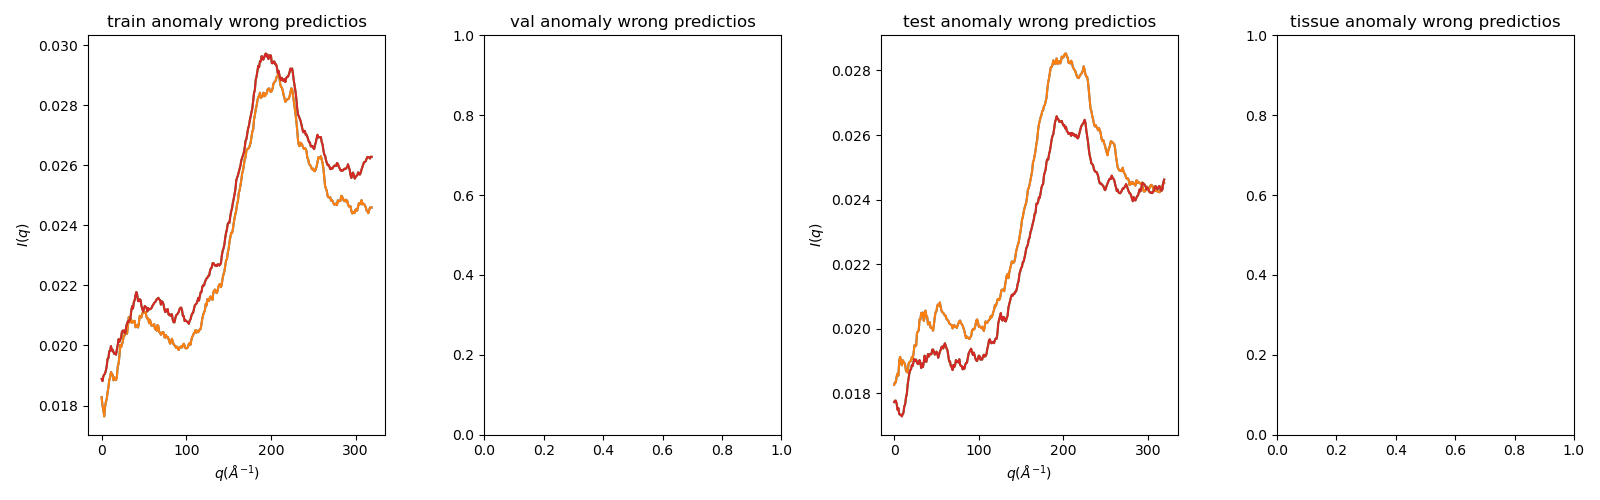

In [41]:
#### method - Anomaly Detection
### Choosing threshold from training dataset
%matplotlib widget
indices_list = [(0,'train', dataset_bkg, training_loader.sampler.indices, 'regular'), (1, 'val', dataset_bkg, validation_loader.sampler.indices, 'regular'), (2, 'test', dataset_bkg, test_loader.sampler.indices, 'regular'), (3, 'tissue', dataset_tissue, np.arange(0,len(dataset_tissue)), 'anomaly')]
percentile = 96.85
thr = 1.5178830414797062e-17 #  ('train', percentile)  # 0.03028420664  ('val', percentile) 
thr_in = thr

def get_loss(model, criterion, label, dataset, indices, input_scale, mode, thr, show_plot=False, print_results = False, ax=None):
    model.eval()
    loss_results = {}
    if isinstance(thr, tuple) and label!=thr[0]:
        return (None, None)
        
    with torch.no_grad():
        if show_plot:
            if not ax:
                f,ax = plt.subplots()
            ax.set_title(f'{label} anomaly wrong predictios')        
        counts = 0
        test_loss = np.array([])
        print(f'---------------------------{label}---------------------------')
        for idx in indices:            
            test, file, frame  = dataset.x[idx], dataset.files[idx], dataset.frames[idx]
            test  = input_scale*torch.tensor(test, dtype=torch.float32)
            test.unsqueeze_(0).unsqueeze_(0)
            ypred = model(test)
            loss  = criterion(test, ypred)
            test_loss = np.hstack((test_loss, loss.item()))
            
            if isinstance(thr, float) and (loss.item() > thr if mode=='regular' else loss.item() < thr):
                if print_results:
                    print(f'{thr, loss.item(), file, frame}')
                if show_plot:
                    ax.plot(input_scale*ypred.squeeze(1).detach().numpy().T,)
                    ax.plot(input_scale*test.squeeze(1).detach().numpy().T, label = file  + str(frame))
                    ax.set_xlabel('$q(\AA^{-1})$')
                    ax.set_ylabel('$I(q)$')
                counts += 1
        
        if isinstance(thr, float):
            accuracy = (len(test_loss)-counts)/len(test_loss)*100
            print(f'threshold is : {thr}')
            print(f'Accuracy : {accuracy:0.4}%')
        else:
            thr = np.percentile(test_loss, percentile)
            print(f'chosen thresold based on {label} loss at percentile of {percentile}: {thr}')
        print(f'{label} stats : ---> ', stats.describe( test_loss))
    return thr, test_loss

plt.close('all')
f, axs = plt.subplots(ncols=len(indices_list), nrows=1, figsize=(16,5))
loss = {}
for indices in indices_list:
    if not isinstance(thr, float):
        indices_list.append(indices)
    
    i, label, dataset, idxs, mode = indices
    thr, loss[label] = get_loss(model, criterion, label, dataset, idxs, input_scale, mode, thr, show_plot=True, print_results = False, ax=axs[i])
plt.tight_layout()

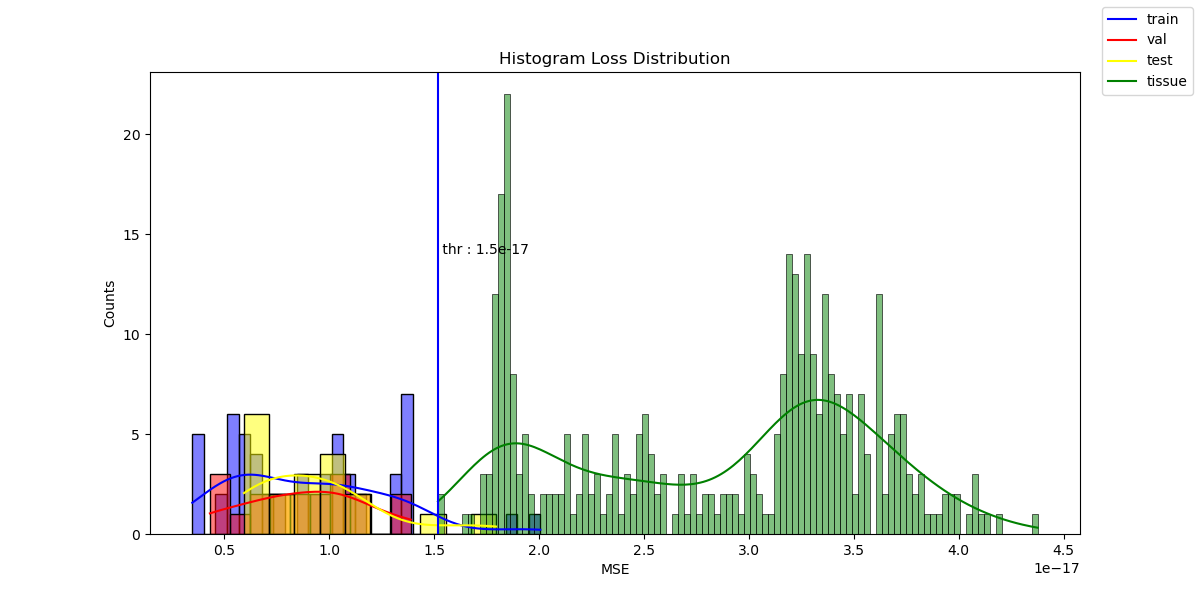

DescribeResult(nobs=56, minmax=(3.469446951953614e-18, 2.0057740190981832e-17), mean=8.966061524139647e-18, variance=1.422923592361044e-35, skewness=0.6552311866701018, kurtosis=0.08220039293952919)
DescribeResult(nobs=19, minmax=(4.30970363562988e-18, 1.3877787807814457e-17), mean=8.795590167824477e-18, variance=8.329055759636217e-36, skewness=0.023551997032914447, kurtosis=-0.8004152715932618)
DescribeResult(nobs=19, minmax=(5.9332962234908005e-18, 1.7943545954635098e-17), mean=9.42927771458091e-18, variance=9.99322824024494e-36, skewness=1.2343307120453242, kurtosis=1.197513093749686)
DescribeResult(nobs=358, minmax=(1.5178830414797062e-17, 4.375840034325945e-17), mean=2.8540622808625075e-17, variance=5.172428468168033e-35, skewness=-0.24049920831797372, kurtosis=-1.285067600228937)


In [42]:
#### method - Anomaly Detection
### visualize histogram
import seaborn as sns
plt.close('all')

lower_threshold = loss['train'].min()
upper_threshold = thr
f = plt.figure(figsize=(12,6))
plt.title('Histogram Loss Distribution')
sns.histplot(loss['train'],bins=30,kde=True, color='blue')
sns.histplot(loss['val'],bins=10,kde=True, color='red')
sns.histplot(loss['test'],bins=10,kde=True, color='yellow')
sns.histplot(loss['tissue'],bins=100,kde=True, color='green')
f.legend(['train','val','test','tissue'])
plt.axvline(upper_threshold, 0.0, 10, color='blue')
plt.xlabel("MSE")
plt.ylabel("Counts")
plt.annotate(f' {percentile}-th percential MSE of {thr_in[0]} dataset' if isinstance(thr_in, tuple) else f' thr : {thr:0.2}' , (thr,14))
plt.show()
print(stats.describe( loss['train']))
print(stats.describe( loss['val']))
print(stats.describe( loss['test']))
print(stats.describe( loss['tissue']))

41 41
Frames : contains 1681 samples
62 122
Frames : contains 7564 samples
62 61
Frames : contains 3782 samples
---------------------------1898_CING-roi0_0_0_masked_intp.h5---------------------------
threshold is : 1.5178830414797062e-17
Accuracy : 98.16%
1898_CING-roi0_0_0_masked_intp.h5 stats : --->  DescribeResult(nobs=1681, minmax=(6.583817526982103e-18, 3.2829640459372094e-17), mean=1.842022082791362e-17, variance=4.9261053117309e-36, skewness=1.6270017405647557, kurtosis=11.57219747302169)
bkg frames - ,56,57,58,59,60,61,62,63,87,95,293,294,362,363,374,375,378,379,380,524,525,908,909,1002,1003,1045,1046,1047,1087,1170,1368
dataset distribution -  (array([0., 1.]), array([1650,   31]))
---------------------------1898_CING-roi0_0_0_masked_intp.h5-------------------Thresholding--------------------------
threshold is ; 0.0211
bkg frames - ,56,57,58,59,60,61,62,63,87,95,293,294,362,363,374,375,378,379,380,524,525,909,1002,1003,1045,1046,1047,1087,1170,1368
dataset distribution -  (arr

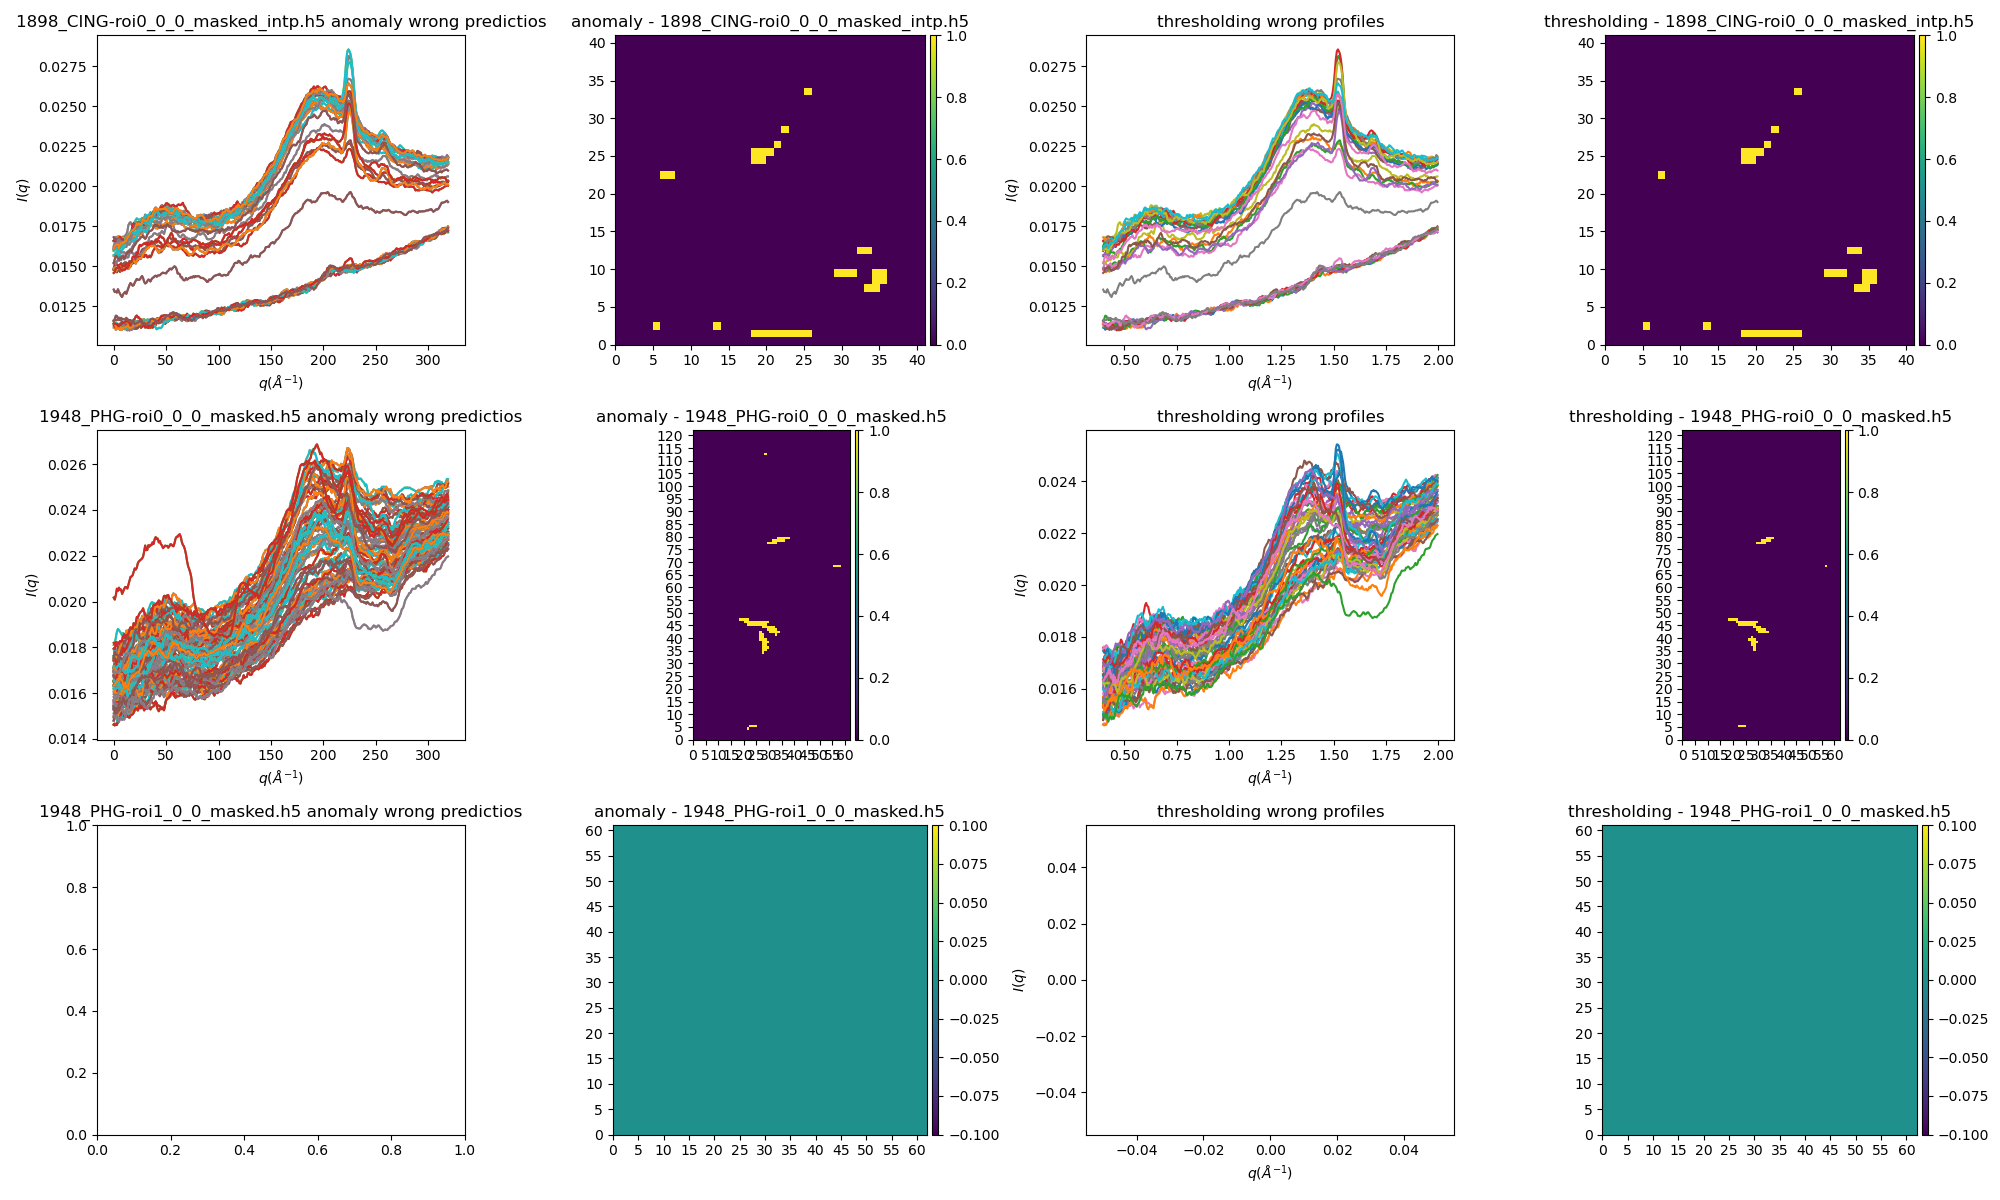

In [43]:
### plot ROIs - choose metho
%matplotlib widget
import sys
sys.setrecursionlimit(10000)

# load mica model
model = LinearModel()
model.to(device)
model.load_state_dict(torch.load(destination))

### parameters
column_names      = {"Frames":1.0}   ### Dummy column
BNL_dir           = '/Volumes/HDD/BNL-Data/Mar-2023'    # '/Volumes/HDD/BNL-Data/Mar-2023'         '/scratch/bashit.a/BNL-Data/Mar-2023'
sub_dir           = "CSV_Conv-8-point"  # CSV_Conv-8-point  CSV
show_plot         = True

### modify here -----------------------------------
input_files         = ["1898_CING-roi0_0_0_masked_intp.h5" , \
                       "1948_PHG-roi0_0_0_masked.h5", \
                       "1948_PHG-roi1_0_0_masked.h5"] # "2068_PHG_2-roi0_0_0_masked_intp.h5"  (42,42) # "1898_CING-roi0_0_0_masked_intp.h5" (41,41) # "1948_EC-roi1_0_0_masked.h5" # "1898_CING-roi0_0_0_masked_intp.h5"  # "1948 V1-roi0_0_0_masked.h5"

input_file_locs     = [f'/Volumes/HDD/BNL-Data/Mar-2023/1898/CSV_Conv-8-point/{input_files[0]}_merged.csv', \
                       f'/Volumes/HDD/BNL-Data/Mar-2023/1948/CSV_Conv-8-point/{input_files[1]}_merged.csv', \
                       f'/Volumes/HDD/BNL-Data/Mar-2023/1948/CSV_Conv-8-point/{input_files[2]}_merged.csv'] 

inputs_width_height = [(41,41), \
                       (62, 122), \
                       (62,61) ]  # (62,61)
### -----------------------------------

indices_list = []
for idx in range(len(input_files)):
    df = pd.DataFrame({"File": [None], "File_Loc": [None], "Frames": [None]}, dtype=str)

    df.at[0, "File"]     = input_files[idx]
    df.at[0, "File_Loc"] = input_file_locs[idx]
    Width, Height          = inputs_width_height[idx]
    print(Width, Height)
    df.at[0, "Frames"]   = str(np.arange(0, Width*Height,dtype=int).tolist())    
    dataset = XrayData(df, column_names, BNL_dir, sub_dir, lidx=lidx, uidx=uidx, mica_sub=mica_sub, scaling=scaling, tissue_sub=tissue_sub)
    
    indices_list.append(( input_files[idx], (Width, Height), dataset, eval(df.at[0, "Frames"]), 'anomaly'))

# indices_list = [(4, input_file, dataset, eval(df.Frames[0]), 'anomaly') , ]
plt.close('all')
f, axs = plt.subplots(ncols=4, nrows=len(indices_list), figsize=(20,12))

def avg_plot(x, y, input_scale, ax ):
    ax.plot(x, input_scale*y)
    ax.set_xlabel('$q(\AA^{-1})$')
    ax.set_ylabel('$I(q)$')
    ax.set_title('thresholding wrong profiles')

def show_heatmap(Width, Height, sel_fr, args, title):
    arr_fr = np.arange(0, Width*Height,dtype=int)
    diff_patterns = np.zeros((Width*Height))
    print('bkg frames - ',*sel_fr, sep=',')
    diff_patterns[ arr_fr[ sel_fr]] = 1
    print('dataset distribution - ',np.unique(diff_patterns, return_counts=True))
    img_orig    = snaking(Width, Height, diff_patterns)
    plot_heat_map_from_data(img_orig, Width, Height, args=args, title= title, cmap="viridis", norm=None, ticks=None, alpha=None)

for idx, indices in enumerate(indices_list):
    label, width_height, dataset, idxs, mode = indices
    Width, Height = width_height

    thr, loss[label] = get_loss(model, criterion, label, dataset, idxs, input_scale, mode, thr, show_plot=show_plot, print_results = False, ax=axs[idx,0])
    sel_fr = np.where(loss[label] < thr)[0]  # thr
    show_heatmap(Width, Height, sel_fr, args=(f,axs[idx,1]), title='anomaly - ' + label)

    print(f'---------------------------{label}-------------------Thresholding--------------------------')
    print(f'threshold is ; {trad_threshold:0.4f}')
    tissue_rep = dataset.x.mean(axis=1)   # .mean(axis=1)    [:,q_idx]
    sel_fr = np.where(tissue_rep < trad_threshold)[0] 
    if show_plot:
        avg_plot(qgrid2[lidx:uidx], dataset.x[sel_fr].T, input_scale, axs[idx,2])
    show_heatmap(Width, Height, sel_fr, args=(f,axs[idx,3]), title='thresholding - ' + label)

plt.tight_layout()

In [44]:
### training_loader - frame counts from dataset_bkg
dataset_summary = pd.DataFrame({"Files": dataset_bkg.files[training_loader.sampler.indices], "bkg_frame": dataset_bkg.frames[training_loader.sampler.indices]})  # training_loader test_loader validation_loader train
dataset_summary.to_clipboard()

with pd.option_context('display.max_colwidth', None):
    df = dataset_summary.groupby(["Files"], as_index=False).size()
    display(df)
    df.to_clipboard()
print(f'Total Samples : {df["size"].sum()}')

Files  \
0           /Volumes/HDD/BNL-Data/Mar-2023/1898/CSV_Conv-8-point/1898_CING-roi0_0_0_masked_intp.h5_merged.csv   
1             /Volumes/HDD/BNL-Data/Mar-2023/1898/CSV_Conv-8-point/1898_EC-roi0_0_0_masked_intp.h5_merged.csv   
2              /Volumes/HDD/BNL-Data/Mar-2023/1898/CSV_Conv-8-point/1898_EC_bkg-roi0_0_0_masked.h5_merged.csv   
3          /Volumes/HDD/BNL-Data/Mar-2023/1898/CSV_Conv-8-point/1898_HIPPO-roi2_0_0_masked_intp.h5_merged.csv   
4           /Volumes/HDD/BNL-Data/Mar-2023/1898/CSV_Conv-8-point/1898_HIPPO_bkg-roi0_0_0_masked.h5_merged.csv   
5                  /Volumes/HDD/BNL-Data/Mar-2023/1898/CSV_Conv-8-point/1898_V1-roi0_0_0_masked.h5_merged.csv   
6             /Volumes/HDD/BNL-Data/Mar-2023/1898/CSV_Conv-8-point/1898_V2-roi0_0_0_masked_intp.h5_merged.csv   
7             /Volumes/HDD/BNL-Data/Mar-2023/1898/CSV_Conv-8-point/1898_V2-roi1_0_0_masked_intp.h5_merged.csv   
8                  /Volumes/HDD/BNL-Data/Mar-2023/1948/CSV_Conv-8-point/1948_EC-roi0_0_0_masked.h5_merged.csv   
9                  /Volumes/HDD/BNL-Data/Mar-2023/1948/CSV_Conv-8-point/1948_EC-roi1_0_0_masked.h5_merged.csv   
10                 /Volumes/HDD/BNL-Data/Mar-2023/1948/CSV_Conv-8-point/1948_EC-roi2_0_0_masked.h5_merged.csv   
11         /Volumes/HDD/BNL-Data/Mar-2023/1948/CSV_Conv-8-point/1948_HIPPO-roi1_0_0_masked_intp.h5_merged.csv   
12                /Volumes/HDD/BNL-Data/Mar-2023/1948/CSV_Conv-8-point/1948_PHG-roi0_0_0_masked.h5_merged.csv   
13                 /Volumes/HDD/BNL-Data/Mar-2023/1948/CSV_Conv-8-point/1948_V2-roi0_0_0_masked.h5_merged.csv   
14                 /Volumes/HDD/BNL-Data/Mar-2023/1948/CSV_Conv-8-point/1948_V2-roi1_0_0_masked.h5_merged.csv   
15          /Volumes/HDD/BNL-Data/Mar-2023/1968/CSV_Conv-8-point/1968_Hippo_CA3-roi0_0_0_masked.h5_merged.csv   
16                 /Volumes/HDD/BNL-Data/Mar-2023/1971/CSV_Conv-8-point/1971_EC-roi0_0_0_masked.h5_merged.csv   
17                 /Volumes/HDD/BNL-Data/Mar-2023/1971/CSV_Conv-8-point/1971_EC-roi1_0_0_masked.h5_merged.csv   
18         /Volumes/HDD/BNL-Data/Mar-2023/1971/CSV_Conv-8-point/1971_Hippo-roi0_0_0_masked_intp.h5_merged.csv   
19         /Volumes/HDD/BNL-Data/Mar-2023/1971/CSV_Conv-8-point/1971_Hippo-roi1_0_0_masked_intp.h5_merged.csv   
20                 /Volumes/HDD/BNL-Data/Mar-2023/1971/CSV_Conv-8-point/1971_V1-roi1_0_0_masked.h5_merged.csv   
21               /Volumes/HDD/BNL-Data/Mar-2023/2068/CSV_Conv-8-point/2068_CING-roi1_0_0_masked.h5_merged.csv   
22           /Volumes/HDD/BNL-Data/Mar-2023/2068/CSV_Conv-8-point/2068_PHG-roi0_0_0_masked_intp.h5_merged.csv   
23         /Volumes/HDD/BNL-Data/Mar-2023/2068/CSV_Conv-8-point/2068_PHG_2-roi0_0_0_masked_intp.h5_merged.csv   
24                 /Volumes/HDD/BNL-Data/Mar-2023/2068/CSV_Conv-8-point/2068_V1-roi0_0_0_masked.h5_merged.csv   
25            /Volumes/HDD/BNL-Data/Mar-2023/2068/CSV_Conv-8-point/2068_V2-roi0_0_0_masked_intp.h5_merged.csv   
26                 /Volumes/HDD/BNL-Data/Mar-2023/2068/CSV_Conv-8-point/2068_V2-roi1_0_0_masked.h5_merged.csv   
27               /Volumes/HDD/BNL-Data/Mar-2023/2191/CSV_Conv-8-point/2191_CING-roi0_0_0_masked.h5_merged.csv   
28              /Volumes/HDD/BNL-Data/Mar-2023/2191/CSV_Conv-8-point/2191_Hippo-roi0_0_0_masked.h5_merged.csv   
29             /Volumes/HDD/BNL-Data/Mar-2023/2191/CSV_Conv-8-point/2191_V2_bkg-roi0_0_0_masked.h5_merged.csv   
30  /Volumes/HDD/BNL-Data/Mar-2023/Misc/CSV_Conv-8-point/2048_B8_UNSTAINED-roi0_0_0_masked_intp.h5_merged.csv   

    size  
0      1  
1      2  
2      1  
3      3  
4      2  
5      3  
6      1  
7      3  
8      1  
9      2  
10     3  
11     1  
12     2  
13     3  
14     2  
15     2  
16     2  
17     2  
18     1  
19     2  
20     1  
21     1  
22     1  
23     2  
24     2  
25     3  
26     2  
27     2  
28     1  
29     1  
30     1

Total Samples : 56


In [45]:
### dataset_tissue - frame counts
dataset_summary = pd.DataFrame({"Files": dataset_tissue.files, "bkg_frame": dataset_tissue.frames})  # training_loader test_loader validation_loader train
dataset_summary.to_clipboard()

with pd.option_context('display.max_colwidth', None):
    df = dataset_summary.groupby(["Files"], as_index=False).size()
    display(df)
    df.to_clipboard()
print(f'Total Samples : {df["size"].sum()}')

Files  \
0    /Volumes/HDD/BNL-Data/Mar-2023/1898/CSV_Conv-8-point/1898_CING-roi0_0_0_masked_intp.h5_merged.csv   
1      /Volumes/HDD/BNL-Data/Mar-2023/1898/CSV_Conv-8-point/1898_EC-roi0_0_0_masked_intp.h5_merged.csv   
2      /Volumes/HDD/BNL-Data/Mar-2023/1898/CSV_Conv-8-point/1898_EC-roi1_0_0_masked_intp.h5_merged.csv   
3   /Volumes/HDD/BNL-Data/Mar-2023/1898/CSV_Conv-8-point/1898_HIPPO-roi2_0_0_masked_intp.h5_merged.csv   
4           /Volumes/HDD/BNL-Data/Mar-2023/1948/CSV_Conv-8-point/1948 V1-roi0_0_0_masked.h5_merged.csv   
5           /Volumes/HDD/BNL-Data/Mar-2023/1948/CSV_Conv-8-point/1948_EC-roi0_0_0_masked.h5_merged.csv   
6           /Volumes/HDD/BNL-Data/Mar-2023/1948/CSV_Conv-8-point/1948_EC-roi1_0_0_masked.h5_merged.csv   
7           /Volumes/HDD/BNL-Data/Mar-2023/1948/CSV_Conv-8-point/1948_EC-roi2_0_0_masked.h5_merged.csv   
8        /Volumes/HDD/BNL-Data/Mar-2023/1948/CSV_Conv-8-point/1948_HIPPO-roi0_0_0_masked.h5_merged.csv   
9   /Volumes/HDD/BNL-Data/Mar-2023/1948/CSV_Conv-8-point/1948_HIPPO-roi1_0_0_masked_intp.h5_merged.csv   
10         /Volumes/HDD/BNL-Data/Mar-2023/1948/CSV_Conv-8-point/1948_PHG-roi0_0_0_masked.h5_merged.csv   
11         /Volumes/HDD/BNL-Data/Mar-2023/1948/CSV_Conv-8-point/1948_PHG-roi1_0_0_masked.h5_merged.csv   
12          /Volumes/HDD/BNL-Data/Mar-2023/1971/CSV_Conv-8-point/1971_EC-roi0_0_0_masked.h5_merged.csv   
13          /Volumes/HDD/BNL-Data/Mar-2023/1971/CSV_Conv-8-point/1971_EC-roi1_0_0_masked.h5_merged.csv   
14  /Volumes/HDD/BNL-Data/Mar-2023/1971/CSV_Conv-8-point/1971_Hippo-roi0_0_0_masked_intp.h5_merged.csv   
15  /Volumes/HDD/BNL-Data/Mar-2023/1971/CSV_Conv-8-point/1971_Hippo-roi1_0_0_masked_intp.h5_merged.csv   

    size  
0      6  
1      5  
2      6  
3     16  
4     34  
5     18  
6     30  
7      3  
8     65  
9     42  
10    10  
11    17  
12    44  
13    20  
14     5  
15    37

Total Samples : 358
